# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [33]:
from google.colab import files
uploaded = files.upload()


Saving cars.csv to cars (1).csv


In [41]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['cars.csv'].decode('utf-8'))) 
print(df.head(5))

  Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin
0  STRING;DOUBLE;INT;DOUBLE;DOUBLE;DOUBLE;DOUBLE;...                        
1  Chevrolet Chevelle Malibu;18.0;8;307.0;130.0;3...                        
2  Buick Skylark 320;15.0;8;350.0;165.0;3693.;11....                        
3  Plymouth Satellite;18.0;8;318.0;150.0;3436.;11...                        
4  AMC Rebel SST;16.0;8;304.0;150.0;3433.;12.0;70;US                        


In [43]:
cars1 = pd.read_csv('cars.csv') 
print (cars1.shape)

(407, 1)


In [46]:
cars = pd.read_csv('cars.csv')
print (cars.shape) 
cars.head()

(407, 1)


,Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin
0,STRING;DOUBLE;INT;DOUBLE;DOUBLE;DOUBLE;DOUBLE;...
1,Chevrolet Chevelle Malibu;18.0;8;307.0;130.0;3...
2,Buick Skylark 320;15.0;8;350.0;165.0;3693.;11....
3,Plymouth Satellite;18.0;8;318.0;150.0;3436.;11...
4,AMC Rebel SST;16.0;8;304.0;150.0;3433.;12.0;70;US


In [76]:
cars.columns

Index(['Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin'], dtype='object')

In [74]:
cars.sort_values('Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin', ascending = True).head(10)

,Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin
104,AMC Ambassador Brougham;13.0;8;360.0;175.0;382...
10,AMC Ambassador DPL;15.0;8;390.0;190.0;3850.;8....
74,AMC Ambassador SST;17.0;8;304.0;150.0;3672.;11...
291,AMC Concord DL 6;20.2;6;232.0;90.00;3265.;18.2...
383,AMC Concord DL;23.0;4;151.0;0;3035.;20.5;82;US
269,AMC Concord d/l;18.1;6;258.0;120.0;3410.;15.1;...
265,AMC Concord;19.4;6;232.0;90.00;3210.;17.2;78;US
323,AMC Concord;24.3;4;151.0;90.00;3003.;20.1;80;US
115,AMC Gremlin;18.0;6;232.0;100.0;2789.;15.0;73;US
41,AMC Gremlin;19.0;6;232.0;100.0;2634.;13.0;71;US


In [75]:
cars.nlargest(10)

TypeError: ignored

In [78]:
cars.Car;MPG;Cylinders;Displacement;Horsepower;Weight;Acceleration;Model;Origin.hist()

AttributeError: ignored

Dataset #2

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!wget https://raw.githubusercontent.com/fivethirtyeight/data/master/us-weather-history/KCLT.csv

--2019-07-11 02:34:30--  https://raw.githubusercontent.com/fivethirtyeight/data/master/us-weather-history/KCLT.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20629 (20K) [text/plain]
Saving to: ‘KCLT.csv’

KCLT.csv            100%[===================>]  20.15K  --.-KB/s    in 0.06s   

2019-07-11 02:34:30 (347 KB/s) - ‘KCLT.csv’ saved [20629/20629]



In [87]:
weather = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/us-weather-history/KCLT.csv')
print (weather.shape)
weather.head()

(365, 13)


,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation
0,2014-7-1,81,70,91,67,89,56,104,1919,2012,0.00,0.10,5.91
1,2014-7-2,85,74,95,68,89,56,101,2008,1931,0.00,0.10,1.53
2,2014-7-3,82,71,93,68,89,56,99,2010,1931,0.14,0.11,2.50
3,2014-7-4,75,64,86,68,89,55,99,1933,1955,0.00,0.10,2.63
4,2014-7-5,72,60,84,68,89,57,100,1967,1954,0.00,0.10,1.65


In [88]:
weather.columns

Index(['date', 'actual_mean_temp', 'actual_min_temp', 'actual_max_temp',
       'average_min_temp', 'average_max_temp', 'record_min_temp',
       'record_max_temp', 'record_min_temp_year', 'record_max_temp_year',
       'actual_precipitation', 'average_precipitation',
       'record_precipitation'],
      dtype='object')

In [91]:
weather.sort_values('actual_min_temp', ascending = False).head(10)

,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation
358,2015-6-24,88,75,100,66,88,55,102,1972,1930,0.00,0.12,1.25
13,2014-7-14,85,74,96,68,89,59,102,2007,1954,0.00,0.12,2.15
359,2015-6-25,86,74,98,67,88,53,102,1889,1914,0.00,0.11,2.76
352,2015-6-18,87,74,100,65,87,52,100,1961,2015,0.00,0.13,1.86
61,2014-8-31,83,74,91,65,86,53,99,1946,1957,0.06,0.12,3.40
1,2014-7-2,85,74,95,68,89,56,101,2008,1931,0.00,0.10,1.53
38,2014-8-8,77,73,81,68,88,55,102,2004,2007,0.00,0.13,1.37
351,2015-6-17,86,73,99,65,87,53,100,1917,1943,0.00,0.12,2.76
53,2014-8-23,82,73,91,67,87,53,103,1930,1983,0.08,0.13,2.74
357,2015-6-23,87,73,100,66,88,53,100,1947,2015,0.00,0.11,1.82


In [93]:
weather.nlargest(10,'actual_mean_temp')

,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation
358,2015-6-24,88,75,100,66,88,55,102,1972,1930,0.00,0.12,1.25
352,2015-6-18,87,74,100,65,87,52,100,1961,2015,0.00,0.13,1.86
357,2015-6-23,87,73,100,66,88,53,100,1947,2015,0.00,0.11,1.82
351,2015-6-17,86,73,99,65,87,53,100,1917,1943,0.00,0.12,2.76
359,2015-6-25,86,74,98,67,88,53,102,1889,1914,0.00,0.11,2.76
1,2014-7-2,85,74,95,68,89,56,101,2008,1931,0.00,0.10,1.53
13,2014-7-14,85,74,96,68,89,59,102,2007,1954,0.00,0.12,2.15
360,2015-6-26,85,70,100,67,88,55,102,1979,1952,1.21,0.11,1.98
349,2015-6-15,84,68,99,65,86,51,99,1933,2015,0.00,0.14,1.16
350,2015-6-16,84,69,99,65,86,52,99,1961,2015,0.00,0.13,3.32


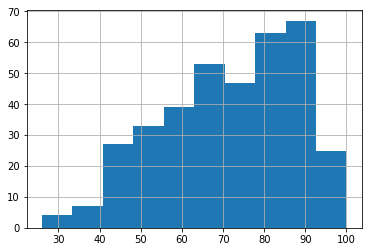

In [96]:
weather.actual_max_temp.hist()
plt.show()

**1.** In my first dataset, I had uploaded a lcoal file which contained data regarding cars and their stats. When sorting values, I had realized that whomever uploaded the data had not seperated the columns individually but rather made the index into one string which contained all of the columns combined. Realizing I was unable to sort these and seperate them, I moved onto a second set of data which contained a history of weather in the United States. I imported the data from gihub into my local notebook and printed the head of the data. The columns were sepreated in this dataset, giving me an ease of access to the different columns of the data. I played around with the data and sorted different columns, and created a histogram of the actual max temperatures. 

**2.** The most challenging part for me was figuring out how to import data into my local notebook. I also struggled with my first set of data and figuring out why it wasn;t allowing me to sort the different columns. Once I realized the error on the columns,  this made it much easier when working with the second set of data. 

**3.** Making the graph was interesting and using the different commands to sort data was also really helpful.  

**4.** I would like to explore different types of graphs with more time since I found them really enjoyable during lecture. I'm also curious as to how I could have possibly seperated the columns in the first set of data. 

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.